## Feature selection

Hybrid method: Recursive feature elimination
This method consists of the following steps:

Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance or  coefficients derived from linear models.

Remove one feature -the least important- and build a machine learning algorithm utilising the remaining features.

Calculate a performance metric of choice: roc-auc, mse, rmse, accuracy, etc.

If the metric decreases by more than an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.

Repeat steps 2-4 until all features have been evaluated.

I call this a hybrid method because:

it derives the importance derived from the machine learning algorithm, like embedded methods

it builds several machine learning models, like wrapper methods.

This method is faster than wrapper methods and often better than embedded methods. In practice, it works extremely well. 

One thing to note is that the minimum drop in performance to decide if a feature should be kept is set arbitrarily. The smaller the drop, the more features will be selected, and vice versa.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, RecursiveFeatureElimination

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

In [4]:
imputer_missForest = IterativeImputer(
    estimator=ExtraTreesRegressor(n_estimators=10, random_state=42),
    max_iter=10,
    random_state=42,
)

imputer_missForest.fit(X_train)
X_train_missForest = imputer_missForest.transform(X_train)
X_test_missForest = imputer_missForest.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [5]:
X_train_missForest_t = pd.DataFrame(
    X_train_missForest, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_missForest_t = pd.DataFrame(
    X_test_missForest, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_missForest_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
constant_step = pipe.named_steps['constant']
quasi_constant_step = pipe.named_steps['quasi-constant']
duplicated_step = pipe.named_steps['duplicated']

print("Constant features removed:", constant_step.features_to_drop_)
print("Quasi-constant features removed:", quasi_constant_step.features_to_drop_)
print("Duplicate features removed:", duplicated_step.features_to_drop_)

Constant features removed: []
Quasi-constant features removed: []
Duplicate features removed: set()


In [8]:
X_train_t = pipe.transform(X_train_missForest_t)
X_test_t = pipe.transform(X_test_missForest_t)

X_train_t.shape, X_test_t.shape

((425, 23), (183, 23))

In [9]:
model = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=2,
    random_state=42,
)

# Define cross-validation strategy
scv = StratifiedKFold(n_splits=5, 
                      shuffle=True, 
                      random_state=42)

# Setup the RFE selector
sel = RecursiveFeatureElimination(
    estimator=model,
    scoring="roc_auc_ovr_weighted",
    threshold=0.0005,
    cv=scv
)

# this may take quite a while, because
# we are building a lot of models with cross-validation
sel.fit(X_train_t, y_train)

RecursiveFeatureElimination(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                            estimator=GradientBoostingClassifier(max_depth=2,
                                                                 n_estimators=10,
                                                                 random_state=42),
                            scoring='roc_auc_ovr_weighted', threshold=0.0005)

In [10]:
# performance of model trained using all features

sel.initial_model_performance_

np.float64(0.8468599851889014)

In [11]:
# drop in performance caused by shuffling the feature

sel.performance_drifts_

{'HipsClusterShadebaseline': np.float64(-0.000874437471749645),
 'ERCsSumVariancebaseline': np.float64(0.000919554793970323),
 'Gender': np.float64(0.00021946843080378198),
 'ERCsVariancebaseline': np.float64(0.0011890827550242733),
 'ERCsCorelationbaseline': np.float64(-0.0005494440108351206),
 'HipsSumVariancebaseline': np.float64(0.00010229240544434859),
 'ERCsASMbaseline': np.float64(0.00033977193361400815),
 'HipsSumAveragebaseline': np.float64(0.0007611046488820161),
 'HipsASMbaseline': np.float64(0.00015841683526451877),
 'ERCsSumAveragebaseline': np.float64(-0.0015763970773354785),
 'ERCsClusterShadebaseline': np.float64(0.002605297833768949),
 'ERCsEntropybaseline': np.float64(0.0022657284155457313),
 'ERCsContrastbaseline': np.float64(-0.0028526052586423933),
 'HipsVariancebaseline': np.float64(-0.0010032071672056997),
 'HipsContrastbaseline': np.float64(-0.003074404494923799),
 'Ageatscreening': np.float64(-0.0014286779605736655),
 'HipsCorelationbaseline': np.float64(0.0036

In [12]:
sel.feature_importances_

HipsClusterShadebaseline      0.000000
ERCsSumVariancebaseline       0.000000
Gender                        0.000777
ERCsVariancebaseline          0.001644
ERCsCorelationbaseline        0.002035
HipsSumVariancebaseline       0.002412
ERCsASMbaseline               0.002888
HipsSumAveragebaseline        0.002941
HipsASMbaseline               0.003058
ERCsSumAveragebaseline        0.003540
ERCsClusterShadebaseline      0.005666
ERCsEntropybaseline           0.008350
ERCsContrastbaseline          0.011993
HipsVariancebaseline          0.011995
HipsContrastbaseline          0.015464
Ageatscreening                0.016931
HipsCorelationbaseline        0.021793
RID                           0.022018
ERCs_thicknessbaseline        0.027174
HipposcampusVolumebaseline    0.031460
HipsEntropybaseline           0.040277
ERCsVolumebaseline            0.072168
MMSE0m                        0.695418
dtype: float64

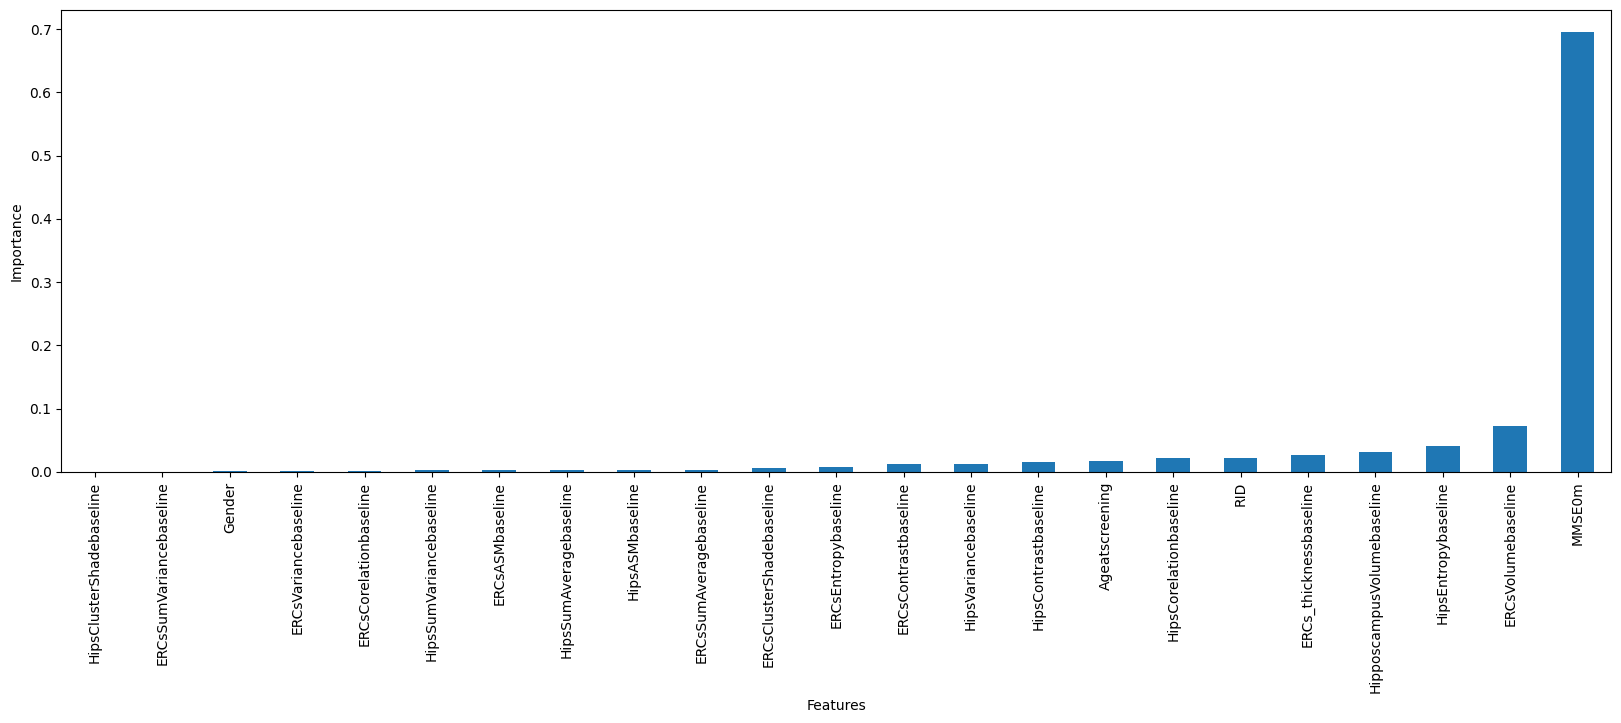

In [13]:
# importance of all features based of initial model
sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

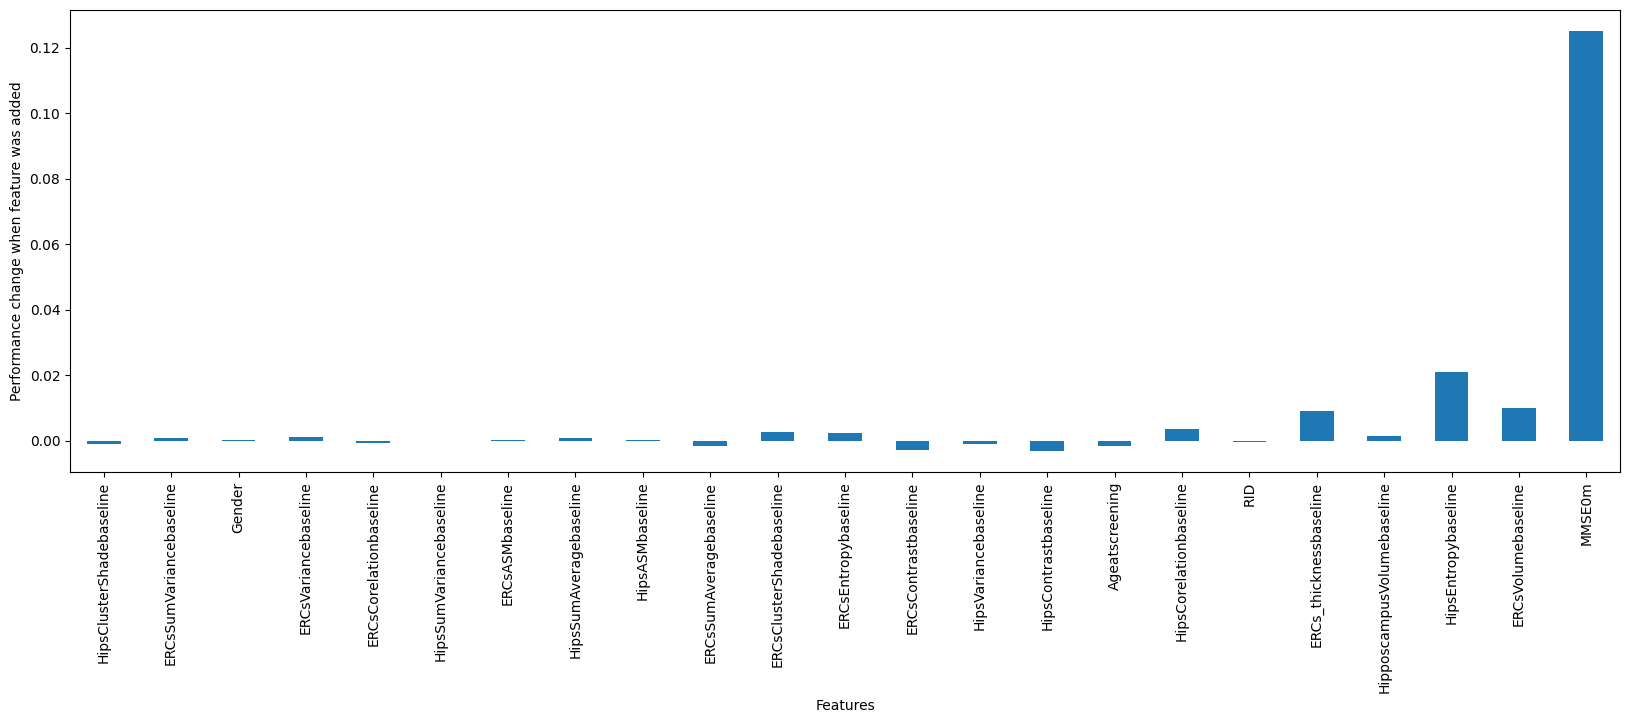

In [14]:
pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [15]:
# Number of features that will be removed

sel.features_to_drop_

['RID',
 'Gender',
 'Ageatscreening',
 'HipsASMbaseline',
 'HipsContrastbaseline',
 'HipsVariancebaseline',
 'HipsSumVariancebaseline',
 'HipsClusterShadebaseline',
 'ERCsASMbaseline',
 'ERCsContrastbaseline',
 'ERCsCorelationbaseline',
 'ERCsSumAveragebaseline']

In [16]:
# select features
X_train_t = sel.transform(X_train)
X_test_t = sel.transform(X_test)

X_train_t.shape, X_test_t.shape

((425, 11), (183, 11))

## Classification Test

In [17]:
def run_model(classifier_name, X_train, y_train):

        # Initialize the model based on classifier_name
        if classifier_name == "Random Forest":
                model = RandomForestClassifier(n_estimators=100, 
                                        max_depth=5, 
                                        random_state=42, 
                                        class_weight="balanced")
                
        elif classifier_name == "XGBoost":
        # XGBClassifier sometimes issues warnings about label encoding. 
        # We disable the use_label_encoder and set an evaluation metric.
                model = XGBClassifier(n_estimators=100, 
                                max_depth=5, 
                                random_state=42,
                                eval_metric="logloss")
        
        elif classifier_name == "NGBoost":
                model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                                      n_estimators=100,
                                      verbose=False) 

        else:
                raise ValueError("Unknown classifier")
                
        kf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": "RFE",
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [18]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", X_train_missForest_t, y_train)
trained_rf_t, metrics_rf_t = run_model("Random Forest", X_train_t, y_train)

trained_xgb_n, metrics_xgb_n = run_model("XGBoost", X_train_missForest_t, y_train)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", X_train_t, y_train)

trained_ngb_n, metrics_ngb_n = run_model("NGBoost", X_train_missForest_t, y_train)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", X_train_t, y_train)

In [19]:
validation_df = pd.concat([metrics_rf_n, metrics_rf_t, metrics_xgb_n, metrics_xgb_t, metrics_ngb_n, metrics_ngb_t])
validation_df_report = validation_df.set_index(["Feature Selection", "Classifier", "Fit Time", "Total Features", "Metric"])
validation_df_report

Mean Train  \
Feature Selection Classifier    Fit Time Total Features Metric                          
RFE               Random Forest 0.274    23             balanced_accuracy       0.891   
                                0.249    11             balanced_accuracy       0.872   
                  XGBoost       0.609    23             balanced_accuracy       1.000   
                                0.370    11             balanced_accuracy       1.000   
                  NGBoost       1.502    23             balanced_accuracy       0.698   
                                1.514    11             balanced_accuracy       0.680   

                                                                           Std Train  \
Feature Selection Classifier    Fit Time Total Features Metric                         
RFE               Random Forest 0.274    23             balanced_accuracy      0.010   
                                0.249    11             balanced_accuracy      0.013   
                  XGBoost       0.609    23             balanced_accuracy      0.000   
                                0.370    11             balanced_accuracy      0.000   
                  NGBoost       1.502    23             balanced_accuracy      0.017   
                                1.514    11             balanced_accuracy      0.019   

                                                                           Mean Test  \
Feature Selection Classifier    Fit Time Total Features Metric                         
RFE               Random Forest 0.274    23             balanced_accuracy      0.575   
                                0.249    11             balanced_accuracy      0.566   
                  XGBoost       0.609    23             balanced_accuracy      0.556   
                                0.370    11             balanced_accuracy      0.550   
                  NGBoost       1.502    23             balanced_accuracy      0.550   
                                1.514    11             balanced_accuracy      0.534   

                                                                           Std Test  
Feature Selection Classifier    Fit Time Total Features Metric                       
RFE               Random Forest 0.274    23             balanced_accuracy     0.062  
                                0.249    11             balanced_accuracy     0.078  
                  XGBoost       0.609    23             balanced_accuracy     0.050  
                                0.370    11             balanced_accuracy     0.032  
                  NGBoost       1.502    23             balanced_accuracy     0.053  
                                1.514    11             balanced_accuracy     0.046

In [20]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="weighted"), 3),
                "recall": round(recall_score(y_train, pred_train, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_train, pred_train, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_train, pred_train_proba, average="weighted", multi_class="ovr"),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="weighted"), 3),
                "recall": round(recall_score(y_test, pred_test, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_test, pred_test, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_test, pred_test_proba, average="weighted", multi_class="ovr"),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "RFE",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": len(X_train.columns),
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [21]:
pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)

pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)

pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)

In [22]:
prediction_df = pd.concat([pred_rf_n, pred_rf_t, pred_xgb_n, pred_xgb_t, pred_ngb_n, pred_ngb_t])
prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
prediction_df_report

Train data  \
Feature Selection Classifier    Classification Time Total Features Metric                             
RFE               Random Forest 0.266               23             accuracy                   0.875   
                                                                   balanced_accuracy          0.881   
                                                                   precision                  0.880   
                                                                   recall                     0.875   
                                                                   f1_weighted                0.872   
                                                                   roc_auc_ovr_weighted       0.979   
                                0.157               11             accuracy                   0.866   
                                                                   balanced_accuracy          0.874   
                                                                   precision                  0.870   
                                                                   recall                     0.866   
                                                                   f1_weighted                0.863   
                                                                   roc_auc_ovr_weighted       0.976   
                  XGBoost       0.086               23             accuracy                   1.000   
                                                                   balanced_accuracy          1.000   
                                                                   precision                  1.000   
                                                                   recall                     1.000   
                                                                   f1_weighted                1.000   
                                                                   roc_auc_ovr_weighted       1.000   
                                0.083               11             accuracy                   1.000   
                                                                   balanced_accuracy          1.000   
                                                                   precision                  1.000   
                                                                   recall                     1.000   
                                                                   f1_weighted                1.000   
                                                                   roc_auc_ovr_weighted       1.000   
                  NGBoost       0.756               23             accuracy                   0.755   
                                                                   balanced_accuracy          0.673   
                                                                   precision                  0.742   
                                                                   recall                     0.755   
                                                                   f1_weighted                0.730   
                                                                   roc_auc_ovr_weighted       0.949   
                                0.515               11             accuracy                   0.755   
                                                                   balanced_accuracy          0.676   
                                                                   precision                  0.754   
                                                                   recall                     0.755   
                                                                   f1_weighted                0.728   
                                                                   roc_auc_ovr_weighted       0.940   

                                                                                         Test data  
Feature Selection Classifier    Classification Time Total Features Metric